# Pre-processing

In this notebook, we will pre-process the data to prepare it for the model. This will greatly reduce the amount of time needed to parse the collection for the IR systems.

---

## Import Required Libraries

Import the necessary libraries, including pandas and matplotlib.

In [1]:
from textprocessor import CustomTextProcessorNoStem
from textprocessor import CustomTextProcessor

import xml.etree.ElementTree as ET
from tqdm import tqdm
import zipfile
import re
import os

C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\thinc\compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\thinc\compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


In [2]:
processor = CustomTextProcessor()

# XML-Coll-withSem
collection_name = "XML-Coll-withSem"
processed_dir = "../lib/processed_data/" + collection_name + "_" + processor.get_text_processor_name() + "/"

os.makedirs(processed_dir, exist_ok=True)

In [3]:
zip_file_path = "../lib/data/practice_05/" + collection_name + ".zip"

We define a function to retrieve the text between the xml tags and then we process the text using our ```TextProcessor``` class. The pre-processed text is then put back to recreate the xml file.

In [4]:
def process_text_in_tags(element):
    if element.text:
        processed_text = ' '.join(processor.pre_processing(element.text))
        element.text = processed_text

    if element.tail:  # Process the tail (text after the closing tag)
        processed_tail = ' '.join(processor.pre_processing(element.tail))
        element.tail = processed_tail

    for child in element:
        process_text_in_tags(child)

In [5]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    xml_file_name = zip_ref.namelist()
    for file in tqdm(xml_file_name, desc="Processing files"):
        with zip_ref.open(file) as xml_file:
            xml_content = xml_file.read().decode('utf-8')

            xml_content = re.sub(r'<\/?b>', '', xml_content)
            xml_content = re.sub(r'<\/?it>', '', xml_content)
            
            root = ET.fromstring(re.sub('&[^;]+;', ' ', xml_content))
            process_text_in_tags(root)

            # Convert the processed XML content to a string
            processed_xml = ET.tostring(root, encoding='unicode')
            processed_xml_file_path = f"{processed_dir}{file.split('/')[1].split('.')[0]}.xml"
            
            # Save the processed XML content to a new XML file
            with open(processed_xml_file_path, 'w', encoding='utf-8') as processed_file:
                processed_file.write(processed_xml)

Processing files: 100%|██████████| 9804/9804 [10:25<00:00, 15.66it/s]


# A small analysis

We want to check what are the differences between the new pre-processing and the old one.

In [18]:
from difflib import SequenceMatcher
from colorama import Fore, Style
from tabulate import tabulate
import pandas as pd

# Function to read a file and return its content as a list of words
def read_words(file_path):
    with open(file_path, 'r') as file:
        return file.read().split()

# Function to compare words and generate a table of differences
def generate_diff_table(file1_words, file2_words):
    matcher = SequenceMatcher(None, file1_words, file2_words)
    diff = matcher.get_opcodes()

    table_data = []
    for opcode, a_start, a_end, b_start, b_end in diff:
        if opcode == 'delete':
            deleted_words = [Fore.RED + file1_words[i] + Style.RESET_ALL for i in range(a_start, a_end)]
            table_data.append([' '.join(deleted_words), 'Deleted', ''])
        elif opcode == 'insert':
            inserted_words = [Fore.GREEN + file2_words[i] + Style.RESET_ALL for i in range(b_start, b_end)]
            table_data.append(['', 'Inserted', ' '.join(inserted_words)])
        elif opcode == 'replace':
            deleted_words = [Fore.RED + file1_words[i] + Style.RESET_ALL for i in range(a_start, a_end)]
            inserted_words = [Fore.GREEN + file2_words[i] + Style.RESET_ALL for i in range(b_start, b_end)]
            # Zip the deleted and inserted words together and construct strings
            changed_words = [
                f"{deleted_word} --> {inserted_word}" 
                for deleted_word, inserted_word in zip(deleted_words, inserted_words)
            ]
            table_data.append([' '.join(deleted_words), 'Deleted', ' '.join(inserted_words)])

    # Create a DataFrame with three specific columns
    df = pd.DataFrame(table_data, columns=['File 1', 'Operation', 'File 2'])
    
    return df


def diff(content1, content2):
    # Read the content of both files as words
    file1_words = content1.split()
    file2_words = content2.split()

    # Generate the table of differences
    df = generate_diff_table(file1_words, file2_words)

    # Remove ANSI escape codes from the DataFrame before displaying
    df_no_colors = df.applymap(lambda s: re.sub(r'\033\[[\d;]+m', '', s))

    # Display the table of differences
    # print(tabulate(df, headers=['File 1', '', 'File 2']))

    return df_no_colors


## A small Example

In [8]:
def get_text_content(element):
    # Start with an empty string
    text_content = ''
    # Loop through each child element
    for child in element:
        # If the child is a sub-element, recursively get its text content
        if len(child) > 0:
            text_content += get_text_content(child)
        # Append the text of the current element
        if child.text:
            text_content += child.text
        # Append any tail text after the element
        if child.tail:
            text_content += child.tail
    return text_content

In [12]:
with open('../lib/data/practice_05/medium/54772.xml', 'rb') as file:
    content = file.read().decode('utf-8')
    root = ET.fromstring(re.sub('&[^;]+;', ' ', content))
    content = ' '.join(root.itertext())
    # content = get_text_content(root)
    content = processor.pre_processing(content)
    with open('./original/54772-2.txt', 'w', encoding='utf-8') as f:
        f.write(' '.join(content))
    

with open('../lib/processed_data/medium_stop671_porter/54772.xml', 'rb') as file:
    xml_content = file.read().decode('utf-8')
    root = ET.fromstring(xml_content)
    xml_content = ' '.join(root.itertext())

with open('../lib/data/practice_05/medium/54772.xml', 'rb') as file:
    content = file.read().decode('utf-8')
    
    # remove all the xml tags
    content = re.sub('<[^>]*>', '', content)
    content = re.sub('&[^;]+;', ' ', content)
    text = processor.pre_processing(content)

    with open('./original/54772.txt', 'w') as f:
        f.write(' '.join(text))

In [14]:
diff('./original/54772.txt', xml_content)

    File 1              File 2
--  --------  --------  --------
 0            Inserted  es


,File 1,Operation,File 2
0,,Inserted,es


In [19]:
# read xml files 
all_stats_df = pd.DataFrame()
# Read xml files and compare with text files
with zipfile.ZipFile('../lib/processed_data/medium_stop671_porter.zip', 'r') as zip_ref:
    xml_file_name = zip_ref.namelist()
    for file in tqdm(xml_file_name, desc="Processing files"):
        with zip_ref.open(file) as xml_file:
            xml_content = xml_file.read().decode('utf-8')
            root = ET.fromstring(xml_content)
            xml_content = ' '.join(root.itertext())
            
            # Generate differences and store in DataFrame
            df = diff(f"./original/{file.split('/')[1].split('.')[0]}.txt", xml_content)
            
            # Extract 'docno' from the file name
            docno = file.split('/')[1].split('.')[0]
            
            # Add 'docno' as a column
            df['docno'] = docno
            
            # Append the DataFrame to the main DataFrame
            all_stats_df = pd.concat([all_stats_df, df], ignore_index=True)
            
# Reorder columns with 'docno' as the first column
all_stats_df = all_stats_df[['docno'] + [col for col in all_stats_df.columns if col != 'docno']]

Processing files:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing files: 100%|██████████| 1000/1000 [00:09<00:00, 105.09it/s]


In [23]:
all_stats_df = all_stats_df[all_stats_df['Operation'] != '']
all_stats_df.head()

,docno,File 1,Operation,File 2
0,101700,fn,Deleted,
1,101700,fn,Deleted,
2,101700,fn,Deleted,
3,101700,fn,Deleted,
4,101700,fn,Deleted,


In [27]:
# search for changement in 153299 for file 1
all_stats_df['File 1'] = 'px'
all_stats_df[all_stats_df['docno'] == '153299']

,docno,File 1,Operation,File 2
225,153299,px,Deleted,
226,153299,px,Deleted,
227,153299,px,Deleted,
228,153299,px,Deleted,
229,153299,px,Deleted,
230,153299,px,Deleted,multipl root
231,153299,px,Deleted,
232,153299,px,Deleted,
233,153299,px,Deleted,
234,153299,px,Deleted,


In [82]:
from collections import Counter

# Create Counters for inserted, deleted, and replaced words
inserted_words_counter = Counter()
deleted_words_counter = Counter()
replaced_words_counter = Counter()

# Process rows in the DataFrame to count words based on operation type
for index, row in all_stats_df.iterrows():
    operation = row['Operation']
    file1_words = row['File 1'].split() if isinstance(row['File 1'], str) else []
    file2_words = row['File 2'].split() if isinstance(row['File 2'], str) else []
    
    # Increment word counts based on operation type
    if operation == 'Inserted':
        inserted_words_counter.update(file2_words)
    elif operation == 'Deleted':
        deleted_words_counter.update(file1_words)
    elif operation == 'Replaced':
        # Count words from both file1 and file2 as replaced words
        replaced_words_counter.update(file1_words + file2_words)

# Display the most common deleted, inserted, and replaced words
print("Most common words deleted:")
print(deleted_words_counter.most_common(10))

print("\nMost common words inserted:")
print(inserted_words_counter.most_common(10))

print("\nMost common words replaced:")
print(replaced_words_counter.most_common(10))


Most common words deleted:
[('linkl', 45), ('px', 42), ('fx', 37), ('sn', 26), ('fn', 15), ('virus', 15), ('nn', 15), ('vg', 15), ('oe', 15), ('mn', 14)]

Most common words inserted:
[('es', 132), ('ing', 46), ('ic', 27), ('key', 12), ('al', 8), ('iti', 5), ('alli', 5), ('er', 4), ('ation', 4), ('ical', 4)]

Most common words replaced:
[]


In [85]:
# total words removed
total_words_removed = sum(deleted_words_counter.values())
print(f"Total words removed: {total_words_removed}")

# total words inserted
total_words_inserted = sum(inserted_words_counter.values())
print(f"Total words inserted: {total_words_inserted}")

Total words removed: 2077
Total words inserted: 274


In [89]:
# frequency of all the removed words
removed_words_freq = deleted_words_counter.items()
# sort the words by frequency
removed_words_freq = sorted(removed_words_freq, key=lambda x: x[1], reverse=True)
print(f"Frequency of all removed words: {removed_words_freq}")

# sum of the frequency of the removed words
removed_words_freq_sum = sum([freq for _, freq in removed_words_freq])
print(f"Sum of the frequency of the removed words: {removed_words_freq_sum}")

Frequency of all removed words: [('linkl', 45), ('px', 42), ('fx', 37), ('sn', 26), ('fn', 15), ('virus', 15), ('nn', 15), ('vg', 15), ('oe', 15), ('mn', 14), ('japanes', 12), ('gx', 12), ('nstate', 12), ('pn', 11), ('autonomiesoth', 11), ('compressionmethod', 9), ('codecpart', 9), ('modelrfc', 9), ('ndimension', 9), ('algorithmfor', 9), ('planta', 9), ('nari', 8), ('ha', 8), ('tn', 8), ('pa', 8), ('deltax', 8), ('line', 7), ('buse', 7), ('ps', 7), ('zp', 7), ('european', 7), ('kth', 7), ('ntupl', 6), ('pq', 6), ('fa', 6), ('xx', 6), ('xs', 6), ('olog', 6), ('gase', 6), ('pk', 6), ('name', 5), ('right', 5), ('valu', 5), ('uun', 5), ('root', 5), ('articleif', 5), ('nbodi', 5), ('decoherenceprevent', 5), ('dsepar', 5), ('bdens', 5), ('bnormal', 5), ('eyr', 5), ('yr', 5), ('cv', 5), ('rrralphatocopherol', 5), ('ge', 4), ('gi', 4), ('index', 4), ('computingtop', 4), ('gn', 4), ('rb', 4), ('multipl', 4), ('qx', 4), ('ns', 4), ('logn', 4), ('eth', 4), ('primal', 4), ('test', 4), ('fy', 4), (

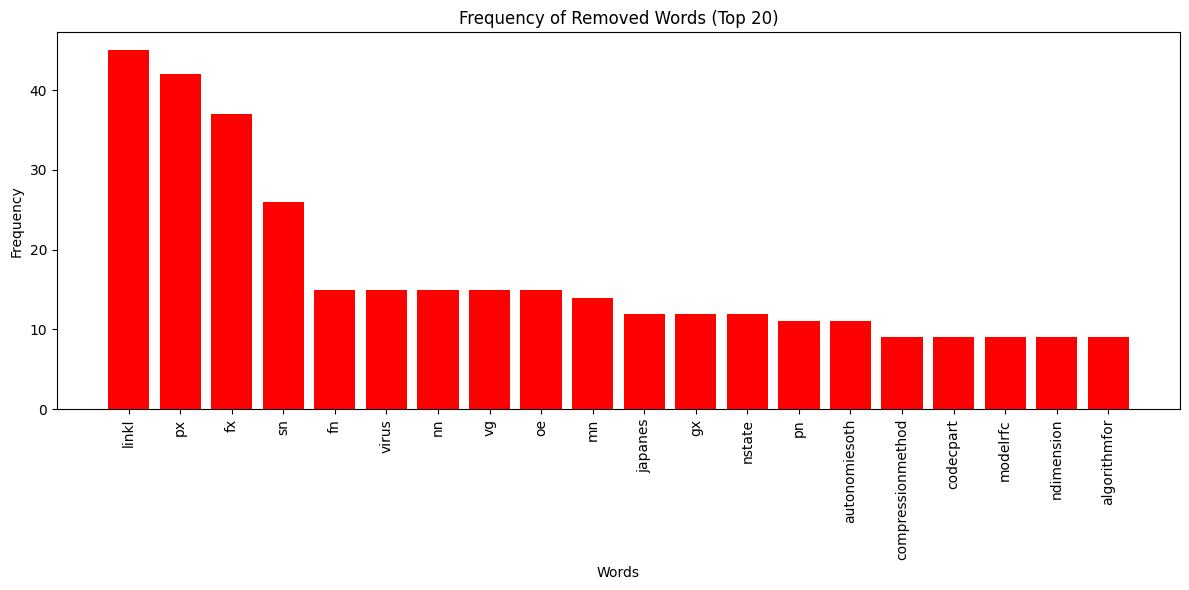

In [92]:
import matplotlib.pyplot as plt

# Get the removed words and their frequencies
removed_words, removed_counts = zip(*removed_words_freq)

# Plotting the frequency of removed words
plt.figure(figsize=(12, 6))
plt.bar(removed_words[:20], removed_counts[:20], color='red')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of Removed Words (Top 20)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
